# Assigment 1  Deep Learning
### by Yeramian Kevin

In [1]:
# Import for the Assigment1
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import pickle


In [2]:
# Global Variable
training_file = "data_batch_1"
validation_file = "data_batch_2"
test_file = "test_batch"
data_folder = "Datasets/cifar-10-batches-py/"

N = 10000
K = 10
d = 3072
lamb = 1.0

## Exercise 1: Training a multi-linear classifier

### Question1

In [3]:
#Q1
# Trasnform a vector of label to a vector of hot-one(dumies)
def hot_one(y):
    Y = []
    for yi in y:
        yihot = [0] * K
        yihot[yi] = 1
        Y.append(yihot)
    return np.array(Y)
    
    
#Functions that load data from file.
def load_batch(file_name):

    with open(file_name, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    y = np.hstack(dict[b'labels'])
    X = dict[b'data'].astype(float).T / 255.0
    Y = hot_one(y).T
    return X,Y,y

In [4]:
#Load of every datasete

X_train, Y_train, y_train = load_batch(data_folder + training_file)
X_test, Y_test, y_test = load_batch(data_folder + test_file)
X_val, Y_val, y_val = load_batch(data_folder + validation_file)

### Question2

In [5]:
#Q2 Inialize W (K,d) and b(K,1)
def initializeWb(K,d):
    mu = 0
    sigma = 0.01
    W =  np.random.normal(mu, sigma, (K,d))
    b = np.random.normal(mu, sigma, (K,1))
    return W,b
W, b = initializeWb(K,d)

### Question3

In [6]:
# Q3 function that eval the network
#function that predict label for X
#Input : - X(d,N)
#        - W(K,d)
#        - b(d,1)
#Output : P ( K×N), the probability for each label for the image in the corresponding column of X
def evaluate_Classifier(X,W,b):
    s = np.dot(W,X) + b # KxN
    aux = np.exp(s)
    summ = np.sum(aux, axis=0) #axis=0 sum by colum so we got 1000 therm to normalize
    p = aux/ summ
    return p

In [7]:
#Test of Question3
W, b = initializeWb(K,d)
print(evaluate_Classifier(X_train[:,:1000],W,b))

[[0.07734642 0.07146392 0.08188224 ... 0.07417983 0.05556265 0.09091742]
 [0.10025188 0.07502446 0.11184124 ... 0.09093274 0.10712233 0.09693415]
 [0.09734799 0.09915055 0.09934272 ... 0.1007051  0.09697317 0.08359595]
 ...
 [0.06955919 0.06664863 0.07439405 ... 0.08451033 0.08210022 0.09128367]
 [0.11893672 0.0974279  0.07647353 ... 0.09101579 0.06880949 0.09823483]
 [0.08289556 0.07287891 0.07695013 ... 0.08690463 0.08508864 0.09001577]]


### Question4

In [8]:
# Q4 function that compute cost
#function that predict label for X
# Input: - X(d,N)
#        - Y(KxN)
#        - W(K,d)
#        - b(d,1)
#        - lambda
# Output: Cost
def compute_Cost(X, Y, W, b, lamb):
    J = 0.0
    p = evaluate_Classifier(X,W,b) # K * N
    for index in range(X.shape[1]):
        J += -np.log(np.dot(p[:,index],Y[:,index]))
    J /= X.shape[1]
    J += lamb * np.sum(np.square(W))
    return J

In [10]:
# Test of question 4
lamb = 1.0
print(compute_Cost(X_train[:,:1], Y_train, W, b, lamb))


5.393503893260901


### Question5

In [11]:
def compute_Accuracy(X, y, W, b):
    p = evaluate_Classifier(X,W,b) # P ( K×N)
    pred = np.argmax(p,axis=0)
    acc = 0.0
    for i in range(len(pred)):
        if(pred[i] == y[i]):
            acc += 1
    
    return acc /len(pred)
    

In [12]:
#Test
compute_Accuracy(X_train[:,:100], y_train,W,b)

0.1

### Question 6

In [13]:
#function that compute the grad
# Input: - X(d,N)
#        - Y(KxN)
#        - P(K×N)
#        - W(K,d)
#        - b(d,1)
#        - lambda
# Output:- grad_W(K×d)
#        - grad_b(K×1)
def compute_Gradients_Slow(X, Y, P, W, b, lamb, h):
    K = W.shape[0]
    d = X.shape[0]
    N = X.shape[1]
    grad_W = np.zeros((K,d))
    grad_b = np.zeros((K,1))

    for i in range(len(b)):
        
        b_try = np.copy(b)
        b_try[i] -= h
        c1 = compute_Cost(X, Y, W, b_try, lamb)
        b_try = np.copy(b)
        b_try[i] += h
        c2 = compute_Cost(X, Y, W, b_try, lamb)
        grad_b[i] = (c2 - c1) / (h * 2)
        
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.copy(W)
            W_try[i][j] -= h
            c1 = compute_Cost(X, Y, W_try, b, lamb)
            W_try = np.copy(W)
            W_try[i][j] += h
            c2 = compute_Cost(X, Y, W_try, b, lamb)
            grad_W[i][j] = (c2 - c1) / (h * 2)
    return grad_W, grad_b


In [14]:
#function that compute the grad
# Input: - X(d,N)
#        - Y(KxN)
#        - P(K×N)
#        - W(K,d)
#        - b(d,1)
#        - lambda
# Output:- grad_W(K×d)
#        - grad_b(K×1)
def compute_Gradients_Num(X, Y, P, W, b, lamb, h):
    K = W.shape[0]
    d = X.shape[0]
    N = X.shape[1]
    grad_W = np.zeros((K,d))
    grad_b = np.zeros((K,1))
    c =  compute_Cost(X, Y, W, b, lamb)
    for i in range(len(b)):
            
        b_try = np.copy(b)
        b_try[i] += h
       
        c2 = compute_Cost(X, Y, W, b_try, lamb)
        grad_b[i] = (c2 - c) / h
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.copy(W)
            W_try[i][j] += h
            c2 = compute_Cost(X, Y, W_try, b, lamb)
            grad_W[i][j] = (c2 - c) / h
    return grad_W, grad_b

#function that compute the grad
# Input: - X(d,N)
#        - Y(KxN)
#        - P(K×N)
#        - W(K,d)
#        - b(d,1)
#        - lambda
# Output:- grad_W(K×d)
#        - grad_b(K×1)
def compute_Gradients(X, Y, p, W, b, lamb):
    K = W.shape[0]
    d = X.shape[0]
    N = X.shape[1]
    grad_W = np.zeros((K,d))
    grad_b = np.zeros((K,1))
    g = - (Y - p) #(KxN)
    
    gx = g.dot(X.T) #K*d

    grad_W += gx
    grad_b += np.mean(g, axis=-1, keepdims=True)
    grad_W /= N
    return grad_W + 2 * lamb * W, grad_b

In [15]:
N = 10000
K = 10
d = 3072
lamb = 0.1
X = X_train[:,:100]
Y = Y_train[:,:100]
p = evaluate_Classifier(X,W,b)
h = 1e-6
grad_W1, grad_b1 = compute_Gradients(X, Y, p, W, b, lamb)

grad_W2, grad_b2 = compute_Gradients_Num(X, Y, p, W, b, lamb, h)

print(np.linalg.norm(grad_b1 - grad_b2,ord=1) / max(h ,np.linalg.norm(grad_b1 ,ord=1) + np.linalg.norm(grad_b2 ,ord=1)))
print(np.linalg.norm(grad_W1 - grad_W2,ord=1) / max(h ,np.linalg.norm(grad_W1 ,ord=1) + np.linalg.norm(grad_W2 ,ord=1)))
grad_W2, grad_b2 = compute_Gradients_Slow(X, Y, p, W, b, lamb, h)

print(np.linalg.norm(grad_b1 - grad_b2,ord=1) / max(h ,np.linalg.norm(grad_b1 ,ord=1) + np.linalg.norm(grad_b2 ,ord=1)))
print(np.linalg.norm(grad_W1 - grad_W2,ord=1) / max(h ,np.linalg.norm(grad_W1 ,ord=1) + np.linalg.norm(grad_W2 ,ord=1)))

#3.4387938012754914e-06
#6.034356916166771e-07
#1.3415812319509035e-06
#2.6146748585888226e-07

6.207404872215878e-07
2.3490729689537573e-06
5.336223367496756e-09
1.521979794366476e-08


### Question 7

In [16]:
def fit(X, Y, y, X_val, Y_val, y_val, lamb, n_batch, eta , n_epochs, K):
    d = X.shape[0]
    N = X.shape[1]
    W, b = initializeWb(K,d)
    lostTrain = []
    lostVal = []
    for _ in range(n_epochs):
        for j in range(int(N / n_batch)):
            
            start = j * n_batch
            end = (j + 1) * n_batch
            X_batch = X[:,start:end]
            Y_batch = Y[:,start:end]
            p = evaluate_Classifier(X_batch,W,b)
            grad_W, grad_b = compute_Gradients(X_batch, Y_batch, p, W, b, lamb)
            W = W -  eta * grad_W
            b = b -  eta * grad_b
        lostTrain.append(compute_Cost(X, Y, W, b, lamb))
        lostVal.append(compute_Cost(X_val, Y_val, W, b, lamb))
    
    return W, b, lostTrain, lostVal

In [17]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 1
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]

n_batch= 100
eta=0.01
n_epochs= 40
W, b, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, eta , n_epochs, K)
print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W, b)))

Accurency on the test = 0.2404


### PLOT LOST

In [18]:
def plot_curve(lostTrain, lostVal):
    rr = range(len(lostVal))
    plt.plot(rr, lostVal,'green')
    plt.plot(rr, lostTrain,'blue')
    plt.title("loss during the training for eta = " + str(eta) + " lambda = " + str(lamb))
    green_patch = mpatches.Patch(color='blue', label="Training loss")
    blue_patch = mpatches.Patch(color='green', label="Validation loss")
    plt.legend(handles=[green_patch, blue_patch])
    plt.savefig(str(lamb) + '_'+ str(eta) + '.png')
    plt.show()

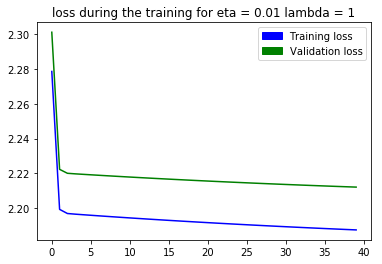

In [19]:
plot_curve(lostTrain, lostVal)

### PLOT W

In [20]:
def plot_W(W):
    for i, row in enumerate(W):
                    img = (row - row.min()) / (row.max() - row.min())
                    plt.subplot(2, 5, i + 1)
                    img = np.rot90(np.reshape(img, (32, 32, 3), order='F'), k=3)
                    plt.imshow(img)
                    plt.axis('off')
                    
    plt.savefig("weights_"+ str(lamb) + '_'+ str(eta) + ".png")
    plt.show()

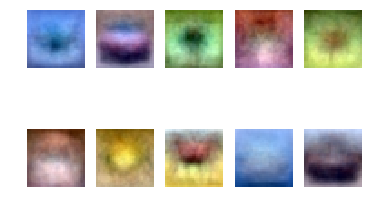

In [21]:
plot_W(W)